In [31]:
import openai
import numpy as np
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Set the API key from environment variable
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_prediction(prompt, samples=30, temperature=0.7):
    outputs = []
    for _ in range(samples):
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature
        )
        try:
            val = float(response['choices'][0]['message']['content'].strip())
            outputs.append(val)
        except ValueError:
            print("Non-numeric response received:", response['choices'][0]['message']['content'])
            continue
    return outputs

# Example prediction
context = "This is a temperature forecasting task in Montreal. Units are in Celsius.\n"
training_data = "Jan, -5\nFeb, -3\nMar, 2\nApr, 10\nMay, 16\nJun, 20\n"
query = "Jul,"

prompt = context + training_data + query
samples = get_prediction(prompt, samples=30)
print("Predictions:", samples)
print("Median:", np.median(samples))
print("95% CI:", np.percentile(samples, [2.5, 97.5]))


Predictions: [24.0, 24.0, 23.0, 24.0, 22.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 23.0, 24.0, 24.0, 24.0, 24.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 23.0, 24.0, 24.0, 23.0]
Median: 24.0
95% CI: [22.725 24.   ]


Median prediction: $178.90
95% CI: [177.864 178.948]


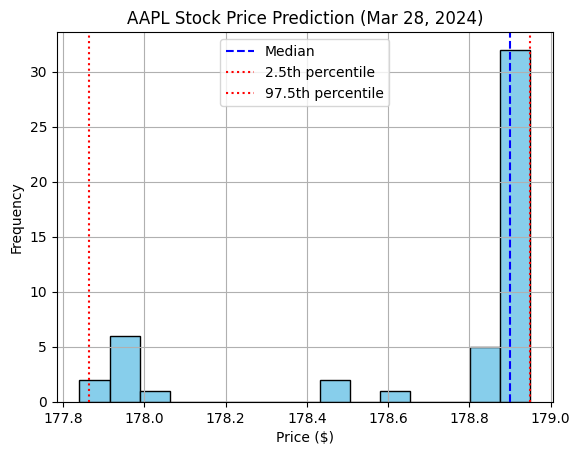

In [32]:
import os
import openai
import numpy as np
import dotenv
import matplotlib.pyplot as plt

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_stock_prediction(prompt, samples=30, temperature=0.7):
    preds = []
    for _ in range(samples):
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature
        )
        try:
            val = float(response['choices'][0]['message']['content'].strip())
            preds.append(val)
        except ValueError:
            continue
    return preds

# Example: Apple stock from 2024-03-20 to 2024-03-27
context = "You are predicting daily closing prices for Apple Inc. stock in USD.\n"
train_data = (
    "Mar 20, 172.39\n"
    "Mar 21, 174.91\n"
    "Mar 22, 175.24\n"
    "Mar 25, 175.10\n"
    "Mar 26, 176.32\n"
    "Mar 27, 177.62\n"
)
query_date = "Mar 28,"  # The day we want to predict

prompt = context + train_data + query_date
samples = get_stock_prediction(prompt, samples=50)

# Display results
median = np.median(samples)
ci_95 = np.percentile(samples, [2.5, 97.5])
print(f"Median prediction: ${median:.2f}")
print(f"95% CI: {ci_95}")

# Plotting
plt.hist(samples, bins=15, color="skyblue", edgecolor="black")
plt.axvline(median, color='blue', linestyle='--', label='Median')
plt.axvline(ci_95[0], color='red', linestyle=':', label='2.5th percentile')
plt.axvline(ci_95[1], color='red', linestyle=':', label='97.5th percentile')
plt.title("AAPL Stock Price Prediction (Mar 28, 2024)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
First 5 rows of TSLA 30-minute data:


,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2024-06-04 04:00:00,TSLA,174.73,177.755,174.020,174.78,394650.0,5171.0,175.766647
2024-06-05 04:00:00,TSLA,175.35,176.130,172.195,174.96,392401.0,5030.0,174.607087
2024-06-06 04:00:00,TSLA,174.44,179.630,172.760,177.99,506074.0,6318.0,177.001968
2024-06-07 04:00:00,TSLA,176.26,179.320,175.585,177.47,309544.0,4118.0,177.335572
2024-06-10 04:00:00,TSLA,176.02,178.515,173.180,173.89,394930.0,4484.0,175.568830



✅ Data saved as 'tsla_30min_past6months.csv'.


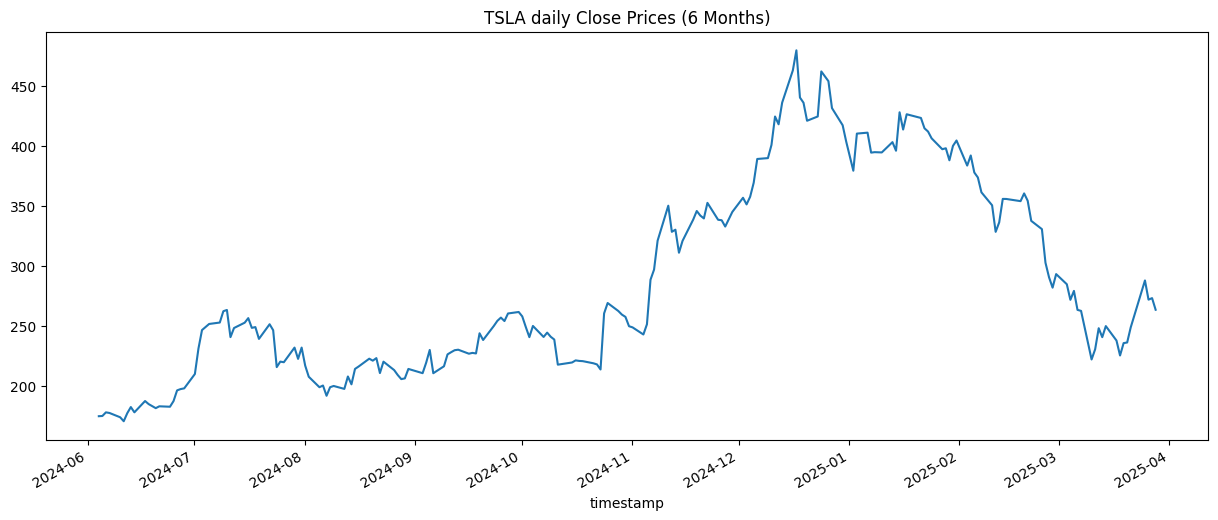

In [42]:
# Install required package
!pip install --quiet alpaca-py

# Imports
import pandas as pd
from datetime import datetime, timedelta
import pytz
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.enums import DataFeed

# Alpaca credentials (ensure these are secure in production!)
API_KEY = os.getenv("API_KEY")
SECRET_KEY = os.getenv("SECRET_KEY")

# Initialize client
client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# Define the time range (last 6 months in UTC)
end_date = datetime.now(pytz.utc)
start_date = end_date - timedelta(days=300)

# Create request parameters
request_params = StockBarsRequest(
    symbol_or_symbols='TSLA',
    start=start_date,
    end=end_date,
    timeframe=TimeFrame(1, TimeFrameUnit.Day),
    feed=DataFeed.IEX,
    limit=10000  # max limit
)

# Fetch bars
bars = client.get_stock_bars(request_params)

# Convert to DataFrame
if bars.df.empty:
    print("No data returned. Check API credentials and parameters.")
else:
    tsla_data = bars.df.reset_index()
    tsla_data.set_index('timestamp', inplace=True)
    tsla_data.index = tsla_data.index.tz_localize(None)  # Remove timezone for modeling

    # Preview and plot
    print("First 5 rows of TSLA 30-minute data:")
    display(tsla_data.head())

    tsla_data['close'].plot(title='TSLA daily Close Prices (6 Months)', figsize=(15,6))

    # Save for reuse
    tsla_data.to_csv('tsla_daily_past_6_months.csv')
    print("\n✅ Data saved as 'tsla_30min_past6months.csv'.")


In [49]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df['close'], seasonal=False, trace=True)
print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1620.173, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1622.061, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1622.066, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1618.412, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1624.020, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.159 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -808.206
Date:                Sun, 30 Mar 2025   AIC                           1618.412
Time:                        17:39:36   BIC                           1621.730
Sample:                             0   HQIC                          1619.754
               

/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: '

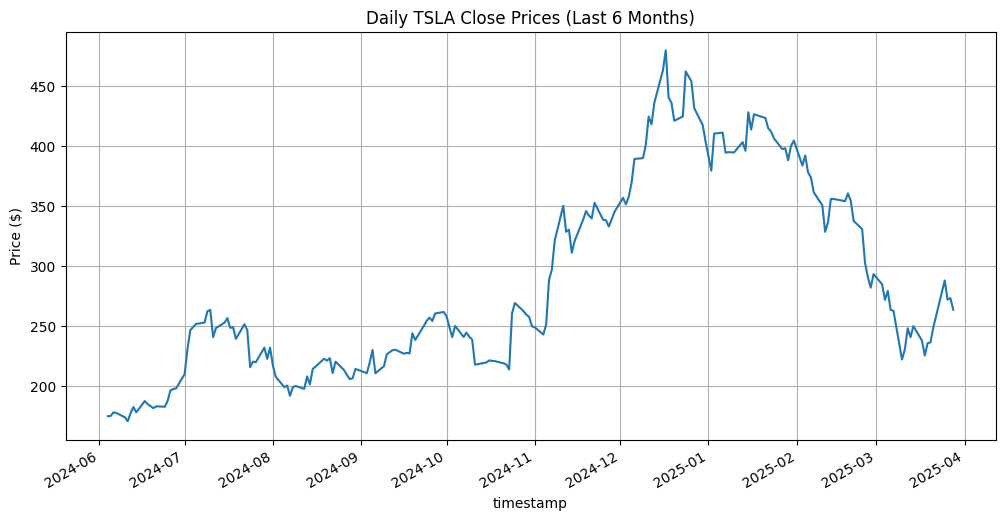

/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karman/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

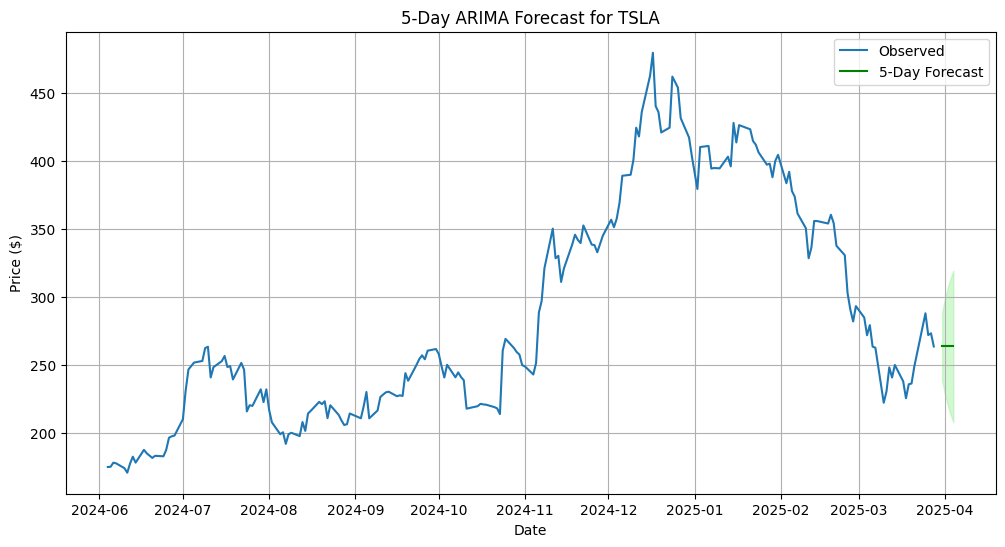

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load and parse data
df = pd.read_csv("tsla_daily_past_6_months.csv", parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample to daily closing prices
daily_close = df['close'].resample('1D').last().dropna()

# Plot historical daily prices
daily_close.plot(title='Daily TSLA Close Prices (Last 6 Months)', figsize=(12, 6))
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Fit ARIMA model
model = ARIMA(daily_close, order=(0, 1, 0))
model_fit = model.fit()

# Forecast next 5 days
forecast_result = model_fit.get_forecast(steps=5)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

last_date = daily_close.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='B')  # 5 business days
forecast.index = forecast_index
conf_int.index = forecast_index

plt.figure(figsize=(12, 6))
plt.plot(daily_close, label='Observed')
plt.plot(forecast, label='5-Day Forecast', color='green')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.4)
plt.title("5-Day ARIMA Forecast for TSLA")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [55]:
forecast

2025-03-31    263.54
2025-04-01    263.54
2025-04-02    263.54
2025-04-03    263.54
2025-04-04    263.54
Freq: B, Name: predicted_mean, dtype: float64

In [58]:
import openai
import os
import pandas as pd
import numpy as np
from datetime import timedelta

# Set your OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")  # Or set manually

# Load and preprocess TSLA data
df = pd.read_csv("tsla_daily_past_6_months.csv", parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
daily_close = df['close'].resample('1D').last().dropna()
last_date = daily_close.index[-1]

# Prepare prompt context with real dates
context = "This is a TSLA stock closing price forecasting task. Prices are in USD.\n"
training_lines = [f"{ts.strftime('%b %d, %Y')}, {round(price, 2)}" for ts, price in daily_close.items()]
training_text = "\n".join(training_lines)

# Sampling function
def get_llmp_prediction(prompt, samples=30, temperature=0.7, model="gpt-4"):
    outputs = []
    attempts = 0
    while len(outputs) < samples and attempts < samples * 2:
        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature
            )
            val = response['choices'][0]['message']['content'].strip().split()[0]
            outputs.append(float(val))
        except Exception:
            attempts += 1
    return np.array(outputs)

# Forecast for the next 5 days using autoregressive prompting
forecast_results = []

for i in range(5):
    forecast_date = last_date + timedelta(days=i+1)
    date_str = forecast_date.strftime('%b %d, %Y')
    prompt = context + training_text + f"\n{date_str},"

    samples = get_llmp_prediction(prompt)
    if len(samples) == 0:
        forecast_results.append({
            "Date": date_str,
            "Median Prediction ($)": "N/A",
            "95% CI Lower ($)": "N/A",
            "95% CI Upper ($)": "N/A"
        })
        continue

    median = np.median(samples)
    lower, upper = np.percentile(samples, [2.5, 97.5])

    forecast_results.append({
        "Date": date_str,
        "Median Prediction ($)": round(median, 2),
        "95% CI Lower ($)": round(lower, 2),
        "95% CI Upper ($)": round(upper, 2)
    })

    # Append this prediction back into the training text
    training_text += f"\n{date_str}, {round(median, 2)}"

# Display results
forecast_df = pd.DataFrame(forecast_results)
print(forecast_df.to_string(index=False))


        Date Median Prediction ($) 95% CI Lower ($) 95% CI Upper ($)
Mar 29, 2025                261.44           259.85           267.46
Mar 30, 2025                 263.1            263.1            263.1
Mar 31, 2025                   N/A              N/A              N/A
Apr 01, 2025                265.84           265.84           265.84
Apr 02, 2025                   N/A              N/A              N/A
